In [1]:
import math
import os
import random
import torch
import sys
sys.path.append('..')
import myd2l

In [2]:
def read_ptb(path='E:\Datasets\ptb\ptb.train.txt'):
    with open(path) as f:
        raw_txt = f.read()
    return [line.split() for line in raw_txt.split('\n')]

In [24]:
sentences = read_ptb()
print(len(sentences), sum(len(line) for line in sentences))

42069 887521


In [25]:
vocab = myd2l.Vocab(sentences, min_freq=10)
print(len(vocab))

6720


In [ ]:
# 下采样，去掉部分出现次数非常多的词，这类词一般无意义
def subsample(sentences, vocab):
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = myd2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    def keep(token):
        return random.uniform(0, 1) < math.sqrt(1e-4 / (counter[token] / num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences], counter)


In [31]:
subsampled, counter = subsample(sentences, vocab)
print(len(subsampled), sum(len(line) for line in subsampled))

42069 351224


In [32]:
def show_list_len_pair_hist(legend, xlist, ylist, xlabel, ylabel):
    ax = myd2l.build_ax(xlabel, ylabel, grid=False)
    _, _, patches = ax.hist([[len(line) for line in xlist], [len(line) for line in ylist]])
    for patch in patches[1].patches:
        patch.set_hatch('/')
    ax.legend(legend)

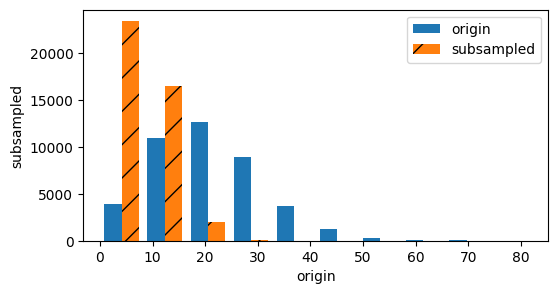

In [33]:
show_list_len_pair_hist(['origin', 'subsampled'], sentences, subsampled, 'origin', 'subsampled')

In [35]:
print(sum(line.count('the') for line in sentences))
print(sum(line.count('the') for line in subsampled))
print(sum(line.count('join') for line in sentences))
print(sum(line.count('join') for line in subsampled))

50770
2076
45
45


In [37]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [393, 2116, 407], [5278, 3055, 1581, 96]]

In [40]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        if len(line) < 2:
            continue

        centers += line
        for i in range(len(line)):
            windows_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - windows_size), min(len(line), i + windows_size + 1)))
            indices.remove(i)
            contexts.append([line[i] for i in indices])

    return centers, contexts

In [41]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1]
中心词 1 的上下文词是 [0, 2, 3]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [2, 4]
中心词 4 的上下文词是 [2, 3, 5, 6]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [4, 5]
中心词 7 的上下文词是 [8, 9]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [7, 8]


In [43]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
print(sum(len(contexts) for contexts in all_contexts))

1543899


In [46]:
class RandomGenerator:
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candicates = []
        self.i = 0
    
    def draw(self):
        if self.i == len(self.candicates):
            self.candicates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candicates[self.i - 1]

In [47]:
generator = RandomGenerator([2, 3, 4])
print([generator.draw() for _ in range(10)])

[3, 1, 2, 3, 3, 1, 3, 1, 3, 2]


In [48]:
def get_negatives(all_contexts, vocab, counter, K):
    # 幂0.75是为了降低高频词的权重，让低频词也有机会被负采样
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negtives = []
        while len(negtives) < len(contexts) * K:
            neg = generator.draw()
            if neg not in contexts:
                negtives.append(neg)
        all_negatives.append(negtives)
    
    return all_negatives

In [49]:
all_negtives = get_negatives(all_contexts, vocab, counter, 5)

In [50]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers.append(center)
        contexts_negatives.append(context + negative + [0] * (max_len - cur_len))
        masks.append([1] * cur_len + [0] * (max_len - cur_len))
        labels.append([1] * len(context) + [0] * (max_len - len(context)))
    
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks), torch.tensor(labels))


In [51]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['center', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

center = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [60]:
def load_data_pth(batch_size, max_window_size, num_noise_words):
    sentences = read_ptb()
    vocab = myd2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negtives = get_negatives(all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
        
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
    
    dataset = PTBDataset(all_centers, all_contexts, all_negtives)
    # 在每次从 DataLoader 中取出数据时，collate_fn 函数会被调用
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True, collate_fn=batchify
    )

    return data_iter, vocab

In [56]:
data_iter, vocab = load_data_pth(512, 5, 5)

In [ ]:
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

center shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])
350208 351224
